<a href="https://colab.research.google.com/github/moon-123/DL-Team-Task/blob/main/%EC%96%91%EB%AC%B8%EA%B8%B0_%EA%B3%BC%EC%A0%9C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 날씨 분류 모델 만들기

# 1. 데이터


### 1-1. 데이터 불러오기


In [1]:
import os

# 본인의 케글 이름과 키 입력

# os.environ['KAGGLE_USERNAME'] = '[kaggle_username]'
# os.environ['KAGGLE_KEY'] = '[kaggle_key]'

In [2]:
!kaggle datasets download -d jehanbhathena/weather-dataset

 99% 580M/587M [00:05<00:00, 101MB/s] 
100% 587M/587M [00:05<00:00, 107MB/s]


In [3]:
!unzip -q weather-dataset.zip

### 1-2. train, validation 나누기

In [4]:
import os
import random
import shutil

def split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2):
    # 클래스 폴더 목록 가져오기
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        validation_class_path = os.path.join(validation_path, class_name)

        # 폴더 생성
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(validation_class_path):
            os.makedirs(validation_class_path)

        # 클래스 폴더 내의 파일 목록 가져오기
        file_list = os.listdir(class_path)

        # 클래스 별 데이터셋 섞기
        random.shuffle(file_list)

        # 클래스 별 데이터셋을 train과 validation으로 나누기
        num_validation = int(len(file_list) * validation_ratio)
        validation_files = file_list[:num_validation]
        train_files = file_list[num_validation:]

        # validation 폴더로 파일 이동
        for file in validation_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(validation_class_path, file)
            shutil.move(src_path, dest_path)

        # train 폴더로 파일 이동
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_path, file)
            shutil.move(src_path, dest_path)

# 사용 예시
dataset_path = 'dataset'
train_path = 'train'
validation_path = 'validation'

split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2)


In [5]:
train_list_dew = os.listdir('train/dew')
valid_list_dew = os.listdir('validation/dew')

print(len(train_list_dew), len(valid_list_dew))

559 139


### 1-3. 모듈 설정, dataset 객체 만들기

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])



# image_datasets = {
#     'train': datasets.ImageFolder('train', data_transforms['train'], target_transform=target_transforms),
#     'validation': datasets.ImageFolder('validation', data_transforms['validation'], target_transform=target_transforms)
# }

image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train']),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'])
}

# label을 float형으로 변경함
# label의 차원이 2D임, 각 요소는 1D
# target_transform=target_transforms를 하지 않으면 각 요소는 long타입에 0D임

cuda


In [7]:
print(len(image_datasets['train']), len(image_datasets['validation']))

5493 1369


In [8]:
image_datasets['train'].classes, len(image_datasets['train'].classes)

(['dew',
  'fogsmog',
  'frost',
  'glaze',
  'hail',
  'lightning',
  'rain',
  'rainbow',
  'rime',
  'sandstorm',
  'snow'],
 11)

### 1-4. 데이터 로더

In [9]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [10]:
x_batch, y_batch = next(iter(dataloaders['train']))
print(y_batch.shape)
print(x_batch.shape)

torch.Size([32])
torch.Size([32, 3, 224, 224])


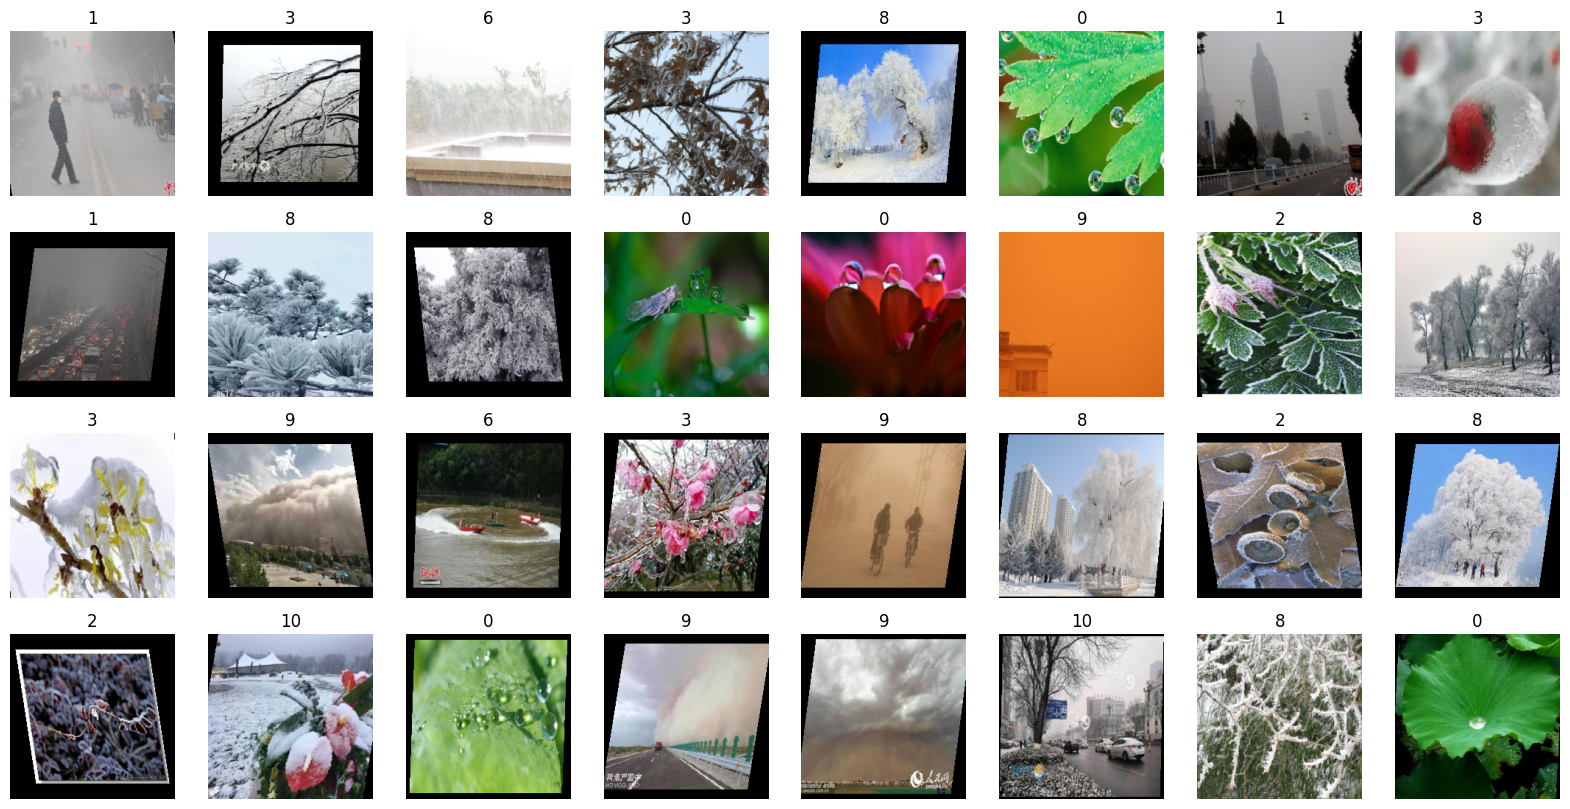

In [11]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# 2. 학습


### 2-1. 전이학습에 사용할 모델 선정

* 기존에 사용한 efficientnet_b4 보다 적합한 모델을 찾아야함
* RESNET101을 사용해보겠음



In [12]:
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# 트러블슈팅하기

In [13]:
model = resnet101(weights=ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 96.0MB/s]


In [14]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
# FC Layer 수정
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터 (W, b)를 업데이트하지 않음

# model.fc = nn.Sequential(
#     nn.Linear(2048, 512),
#     nn.ReLU(),
#     nn.Linear(512, 11)
# ).to(device)

# model.fc = nn.Sequential(
#     nn.Linear(2048, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
#     nn.Linear(512, 11)
# ).to(device)

# model.fc = nn.Sequential(
#     nn.Linear(2048, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 32),
#     nn.ReLU(),
#     nn.Linear(32, 11)
# ).to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 11)
).to(device)

model = model.to(device)


In [16]:
imgs, label = next(iter(dataloaders['train']))
# y_pred = model(dataloaders['train'].)
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=11, bias=True)
)

In [17]:
# 학습
# optimizer: Adam
# epochs: 10
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001) # fc 파라미터와 다름

epochs = 10

for epoch in range(epochs+1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_loss = 0
        sum_acc = 0
        # cnt = 0

        length = len(dataloaders[phase])
        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_loss = sum_loss + loss.item()

            y_prob = nn.Softmax(1)(y_pred)

            y_pred_index = torch.argmax(y_prob, axis=1)

            accuracy = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_acc = sum_acc + accuracy

            # print(f'{phase:10s}: running {cnt}/{length} Loss: {loss:.6f} Accuracy: {accuracy:.2f}%')
            # cnt += 1

        avg_loss = sum_loss / len(dataloaders[phase])
        avg_acc = sum_acc / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    0/10 Loss: 1.288839 Accuracy: 54.57%
validation: Epoch    0/10 Loss: 0.602076 Accuracy: 80.06%
train     : Epoch    1/10 Loss: 0.657161 Accuracy: 77.55%
validation: Epoch    1/10 Loss: 0.481166 Accuracy: 84.64%
train     : Epoch    2/10 Loss: 0.528825 Accuracy: 82.84%
validation: Epoch    2/10 Loss: 0.444531 Accuracy: 86.43%
train     : Epoch    3/10 Loss: 0.475130 Accuracy: 84.54%
validation: Epoch    3/10 Loss: 0.379846 Accuracy: 89.01%
train     : Epoch    4/10 Loss: 0.431139 Accuracy: 86.55%
validation: Epoch    4/10 Loss: 0.379546 Accuracy: 88.40%
train     : Epoch    5/10 Loss: 0.411497 Accuracy: 87.07%
validation: Epoch    5/10 Loss: 0.389832 Accuracy: 87.97%
train     : Epoch    6/10 Loss: 0.372684 Accuracy: 88.47%
validation: Epoch    6/10 Loss: 0.355153 Accuracy: 90.13%
train     : Epoch    7/10 Loss: 0.345431 Accuracy: 88.93%
validation: Epoch    7/10 Loss: 0.348026 Accuracy: 89.69%
train     : Epoch    8/10 Loss: 0.352233 Accuracy: 89.47%
validation: Ep

In [19]:
torch.save(model.state_dict(), 'weather_ResNet101_model.pth')

# Resnet101


---


## 1차시도
batch size: 32, shuffle: True, lr:0.001

### Model(FC)
```
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=11, bias=True)
)
```
### Result
```
train     : Epoch   10/10 Loss: 0.131252 Accuracy: 95.56%
validation: Epoch   10/10 Loss: 0.466486 Accuracy: 88.61%
```

filename: model1.pth

---


## 2차시도
batch size: 32, shuffle: True, lr:0.001

### Model(FC)
```
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=11, bias=True)
)
```
### Result
```
train     : Epoch   10/10 Loss: 0.151008 Accuracy: 94.49%
validation: Epoch   10/10 Loss: 0.487187 Accuracy: 87.31%
```
filename: x


---

## 3차시도
batch size: 32, shuffle: True, lr:0.001

### Model(FC)
```
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=11, bias=True)
)
```
### Result
```
train     : Epoch   10/10 Loss: 0.183164 Accuracy: 94.09%
validation: Epoch   10/10 Loss: 0.469859 Accuracy: 87.23%

```
* Train 정확도와 Validation 정확도의 차이가 많이 나는걸 보아 과적합이 일어났다고 판단
* early stop 혹은 drop out 사용이 필요


filename: model3.pth


---




# Resnet101 - 드롭아웃 추가

## 1차시도 ✓
batch size: 32, shuffle: True, lr:0.001

### Model(FC)
```
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=11, bias=True)
)
```
### Result
```
train     : Epoch   10/10 Loss: 0.333478 Accuracy: 89.65%
validation: Epoch   10/10 Loss: 0.388321 Accuracy: 88.00%
```
* 드롭아웃을 많이 추가하여 과적합이 잡힌 것 같다.
* 혹시나 과소적합이진 않을까?
* 학습률을 높여서 확인해보자.

filename: model4.pth


---

## 2차시도
batch size: 32, shuffle: True, lr:0.002

### Model(FC)
```
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=11, bias=True)
)
```
### Result
```
train     : Epoch   10/10 Loss: 0.389684 Accuracy: 88.73%
validation: Epoch   10/10 Loss: 0.476691 Accuracy: 87.11%
```
* 1차시도와의 정확도 차이가 1%로 작지만 train, validation간의 차이는 1차시도보다 줄었음.
* 1차시도가 더 좋은 모델이라고 판단됨!

filename: model5.pth

```
train     : Epoch   10/10 Loss: 0.310483 Accuracy: 90.70%
validation: Epoch   10/10 Loss: 0.347909 Accuracy: 89.22%
```